In [2]:
import time
import pandas as pd
from itertools import cycle
import gpflow
import numpy as np
from gpflow.utilities import print_summary, positive
from gpflow.ci_utils import ci_niter
from gpflow.optimizers import NaturalGradient
from gpflow import set_trainable
import tensorflow as tf
import tensorflow_probability as tfp
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from collections import namedtuple
import statsmodels.api as sm
import dill as pickle
from functools import partial

sns.set(style="white")
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
pd.set_option('display.max_colwidth', -1)

gpflow.config.set_default_float(np.float64)
gpflow.config.set_default_summary_fmt("notebook")

<ipython-input-2-89ae1d422de2>:24: FutureWarning: Passing a negative integer is deprecated in version 1.0 and will not be supported in future version. Instead, use None to not limit the column width.
  pd.set_option('display.max_colwidth', -1)


# Dataset

## Mobility

In [3]:
mobility_data = pd.read_csv(
    "./Data/Google/Global_Mobility_Report.csv", 
    encoding="ISO-8859-1", 
    parse_dates=["date"],
    dayfirst=True
)
mobility_data_us = mobility_data[
    (mobility_data["country_region"]=="United States") & 
    (~mobility_data["sub_region_1"].isnull()) &
    (mobility_data["sub_region_2"].isnull())
]
mobility_data_us_temp = mobility_data_us.iloc[:,7:] # keep only relevant columns
mobility_data_us_temp["state"] = mobility_data_us["sub_region_1"]
mobility_data_us_temp.iloc[:,1:-1] = mobility_data_us_temp.iloc[:,1:-1].apply(lambda x: x/100 + 1)
mobility_data_us =  mobility_data_us_temp.reset_index(drop=True)
mobility_data_us = pd.DataFrame({
    "state": mobility_data_us["state"],
    "date": mobility_data_us["date"],
    "HOME": mobility_data_us['residential_percent_change_from_baseline'],
    "WORK": mobility_data_us['workplaces_percent_change_from_baseline'],
    "RECREATIONAL": mobility_data_us['retail_and_recreation_percent_change_from_baseline'],
    "OTHER": mobility_data_us.iloc[:,2:5].mean(axis=1)
})

processed_dfs = []

for state in mobility_data_us["state"].unique():
    d = mobility_data_us[mobility_data_us["state"] == state].copy()
    
    d["HOME"] = d["HOME"].rolling(7).median()
    d["WORK"] = d["WORK"].rolling(7).median()
    d["RECREATIONAL"] = d["RECREATIONAL"].rolling(7).median()
    d["OTHER"] = d["OTHER"].rolling(7).median()

    processed_dfs.append(d)
    
mobility_data_us = pd.concat(processed_dfs)

/Users/georgiospapadopoulos/opt/anaconda3/envs/hyperion/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3155: DtypeWarning: Columns (4) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


## Cases

In [4]:
# COVID Cases from Microsoft, includes Recovered and Infected
ms_covid = pd.read_csv(
    "./Data/Microsoft/COVID_CASES.csv", 
    encoding="ISO-8859-1",
    parse_dates=["Updated"],
    dayfirst=False
)
ms_us_covid = ms_covid[
    (ms_covid["Country_Region"]=="United States") & 
    (~ms_covid["AdminRegion1"].isnull()) &
    (ms_covid["AdminRegion2"].isnull())
]
ms_us_covid = ms_us_covid.loc[:,["AdminRegion1", "Updated", "Confirmed", "ConfirmedChange", "Deaths", "Recovered"]]
ms_us_covid.rename(columns={"AdminRegion1": "state"}, inplace=True)
ms_us_covid.reset_index(drop=True, inplace=True)
population = pd.read_excel(
    "./Data/Population/US_population_raw_data.xls",
)
STATE_POPULATION = dict(zip(population[1:].Location, population[1:].COVIDTotal))

processed_dfs = []

for state in ms_us_covid["state"].unique():
    d = ms_us_covid[ms_us_covid["state"] == state]
    d = d.fillna(method='ffill').fillna(0)
    d["I"] = d["Confirmed"] - d["Deaths"] - d["Recovered"]

    d["S"] = int(STATE_POPULATION[state]) - d["I"]

    d["ConfirmedChange"] = np.log(d["ConfirmedChange"].rolling(7).median()+1)
    d["I"] = np.log(d["I"].rolling(7).median()+1)
    d["S"] = np.log(d["S"].rolling(7).median()+1)

    d.dropna(inplace=True)
    processed_dfs.append(d)
    
ms_us_covid = pd.concat(processed_dfs)
ms_us_covid["WEEKDAY"] = (ms_us_covid["Updated"].dt.dayofweek < 5).astype(int)
ms_us_covid["index"] = ms_us_covid["Updated"].dt.dayofyear

## Merge

In [5]:
final_data = ms_us_covid.merge(
    mobility_data_us, how='left', left_on=["state", "Updated"], right_on=["state", "date"]
)
final_data.dropna(inplace=True)
final_data.set_index("state", inplace=True)

In [6]:
final_data.to_pickle("tmp/final_data.pkl")

# Model

In [7]:
times = None
for s in final_data.index.unique():
    s_times = set(final_data.loc[s, 'Updated'].unique())
    if times is None:
        times = s_times
    else:
        times = times.intersection(s_times)

In [8]:
train_times, test_times = sorted(times)[:-14], sorted(times)[-14:]

train_data = final_data[final_data['Updated'].isin(train_times)]
test_data = final_data[final_data['Updated'].isin(test_times)]

ORDER = 7

N  = final_data.index.nunique()
T_train = len(train_times) - ORDER + 1
T_test = len(test_times)
n_inducing_points = 15

In [9]:
# The preprocessing should be done for now outside the script because it doesn't work as it is supposed to
# with the previous code. The global variables kept the last scaled state and then caused issues with the values in the kernels
def scale_the_data(data, name):
    global y_scaler, x_scaler
    
    data = data.copy()
    data.reset_index(inplace=True, drop=True)
    t = data[["Updated"]]
    y = data[["ConfirmedChange"]]
    X = pd.DataFrame({
        "index": data["index"],
        "S": data["S"],
        "I": data["I"],
        "HOME": data["HOME"],
        "WORK": data["WORK"],
        "RECREATIONAL": data["RECREATIONAL"],
    }, index=data.index)[[
        "index",
        "S",
        "I",
        "HOME", 
        "WORK", 
        "RECREATIONAL"
    ]]
    
    y_scaler = preprocessing.StandardScaler().fit(y)
    x_scaler = preprocessing.StandardScaler().fit(X)
    
    return y_scaler, x_scaler

In [10]:
data_scalers = {
    state: scale_the_data(train_data.loc[state], state)
    for state in train_data.index.unique()
}

In [11]:
def prepare_data(data, name):
    
    data = data.copy()
    data.reset_index(inplace=True, drop=True)
    t = data[["Updated"]]
    y = data[["ConfirmedChange"]]
    X = pd.DataFrame({
        "index": data["index"],
        "S": data["S"],
        "I": data["I"],
        "HOME": data["HOME"],
        "WORK": data["WORK"],
        "RECREATIONAL": data["RECREATIONAL"],
    }, index=data.index)[[
        "index",
        "S",
        "I",
        "HOME", 
        "WORK", 
        "RECREATIONAL"
    ]]
    
    if data_scalers is None :
        raise RuntimeError("Data must be scaled first")
        
    y_scaled = data_scalers[name][0].transform(y)
    X_scaled = data_scalers[name][1].transform(X)
    
    return X_scaled, y_scaled


def train_for_state(name, data):
    print(name)

    X_train, y_train = prepare_data(data, name)
    
    Z = X_train[
                np.random.randint(X_train.shape[0], size=n_inducing_points), 0
            ]
    for col in range(1, X_train.shape[1]):
        Z = np.vstack([
            Z, X_train[
                np.random.randint(X_train.shape[0], size=n_inducing_points), col
            ]
        ])

    model_params = {
        'kernel': (
            gpflow.kernels.SquaredExponential(lengthscales=np.ones(X_train.shape[1])) +
            gpflow.kernels.Linear() +
            gpflow.kernels.RationalQuadratic(lengthscales=np.ones(X_train.shape[1]))
        ), 

        'inducing_variable': (Z.T),
        'num_data': (X_train.shape[0])
    }



    model = gpflow.models.SVGP(
        likelihood=gpflow.likelihoods.Gaussian(),
        **model_params
    )

    set_trainable(model.q_mu, False)
    set_trainable(model.q_sqrt, False)
    
    variational_optimizer = gpflow.optimizers.NaturalGradient(gamma=1.0)
    model_variables_optimizer = tf.optimizers.Adam(0.01)
    
    objective_closure = model.training_loss_closure((X_train, y_train))
    
    elbo = []
    start = time.time()

    for _ in range(gpflow.ci_utils.ci_niter(1000)):
        model_variables_optimizer.minimize(
            objective_closure,
            model.trainable_variables
        )
        variational_optimizer.minimize(
            objective_closure,
            [(model.q_mu, model.q_sqrt)]
        )
        elbo.append(model.elbo((X_train, y_train)))
    
    end = time.time()
    print(end - start)

    mean_train, var_train = model.predict_y(X_train)
    #y_train_pred = y_scaler.inverse_transform(mean_train.numpy())
    #y_train_true = y_scaler.inverse_transform(y_train)

    #res = y_train_true - y_train_pred
    res = y_train - mean_train.numpy()
    
    return model, res, var_train

## $K(X, X)$

### Marginal Fitting

In [11]:
results_states = {
    state: train_for_state(state, train_data.loc[state])
    for state in train_data.index.unique()
}

Alaska
68.19915318489075
Alabama
65.00490307807922
Arkansas
76.98861694335938
Arizona
74.80065178871155
California
82.46964907646179
Colorado
72.3715500831604
Connecticut
73.346018075943
District of Columbia
69.47765898704529
Delaware
78.73450112342834
Florida
79.6524589061737
Georgia
76.75548315048218
Hawaii
75.25277519226074
Iowa
88.01391005516052
Idaho
78.51491117477417
Illinois
76.4841411113739
Indiana
73.55175495147705
Kansas
64.20974087715149


In [13]:
# Create a plot dataframe from the residual data
data_frame = pd.DataFrame(columns=results_states.keys())
for i, (s, (_, r, var)) in enumerate(results_states.items()):
    data_frame.loc[:, s] = r.reshape(-1, )
data_frame_melt = data_frame.melt(var_name='state', value_name='residual')

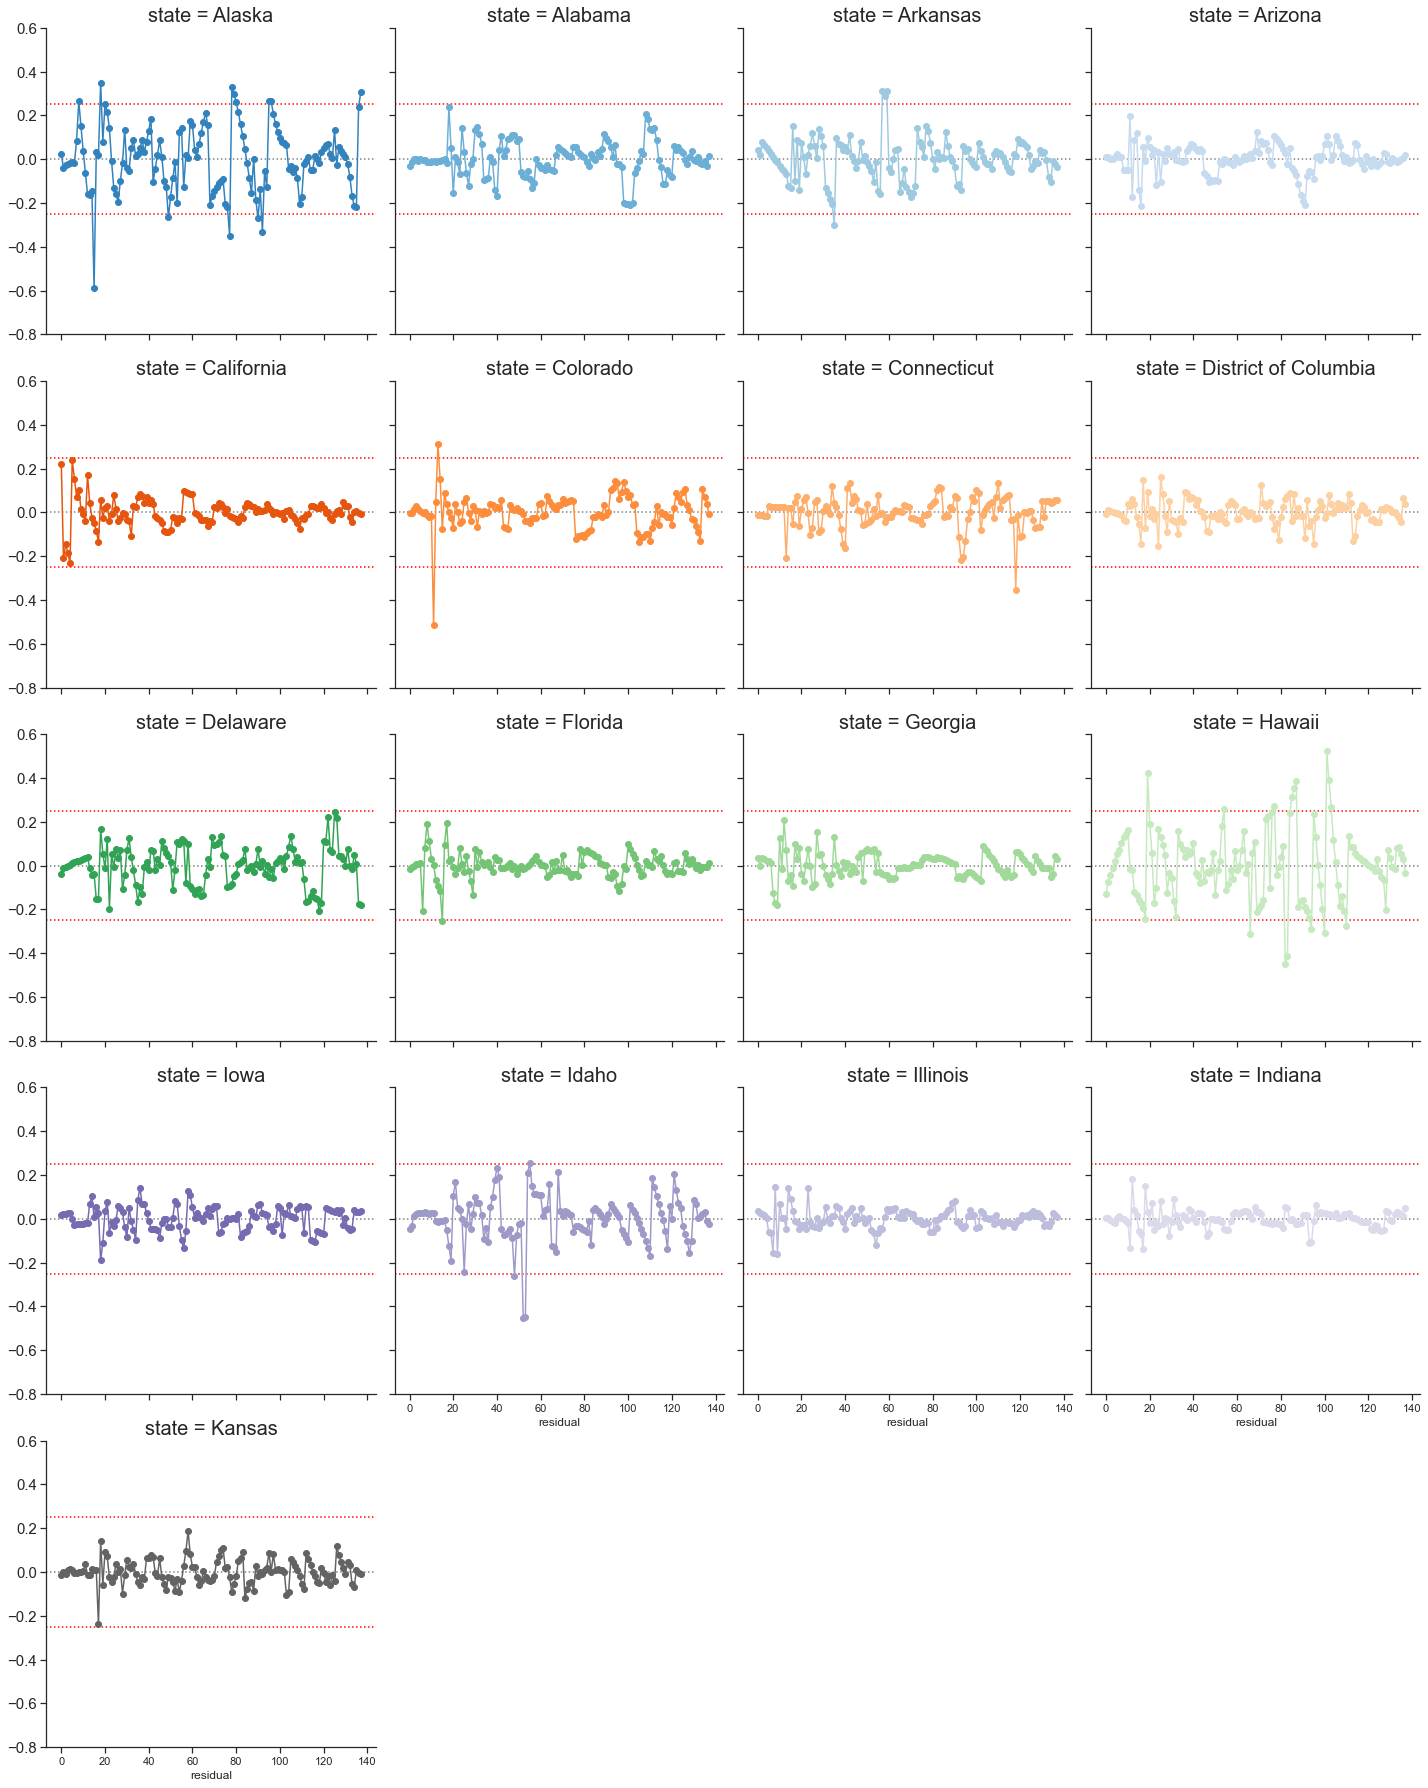

In [14]:
sns.set_theme(style="ticks")

# Initialize a grid of plots with an Axes for each walk
grid = sns.FacetGrid(data_frame_melt, col="state", hue="state", palette="tab20c",
                     col_wrap=4, height=5)

# Draw a horizontal line to show the starting point
grid.map(plt.axhline, y=0, ls=":", c=".5")
grid.map(plt.axhline, y=.25, ls=":", c="red")
grid.map(plt.axhline, y=-.25, ls=":", c="red")

# Draw a line plot to show the trajectory of each random walk
grid.map(plt.plot, "residual", marker="o")

# Adjust the tick positions and labels
grid.set_titles(size = 20)
grid.set_yticklabels(size = 15)

# Adjust the arrangement of the plots
grid.fig.tight_layout(w_pad=1)

### Marginal Kernels

This is the inducing point Kmm kernel with dimensions $255\times 255$, with $17$ states and $15$ inducing points. The inducing points have been optimised using Natural Gradients. 

In [17]:
ks_mm = np.zeros((n_inducing_points*N, n_inducing_points*N))
for s_i, (state, (m_i, r_i, v_i)) in enumerate(results_states.items()):
    k = m_i.kernel(m_i.inducing_variable.Z).numpy()
    ks_mm[s_i*n_inducing_points:(s_i+1)*n_inducing_points, s_i*n_inducing_points:(s_i+1)*n_inducing_points] = k

In [18]:
ks_mm.shape

(255, 255)

### White noise

In [19]:
np.random.seed(123)

dates = pd.date_range(train_data[["Updated"]].min().values[0], train_data[["Updated"]].max().values[0]).values
u0 = np.random.normal(size=len(dates))

u0 = pd.DataFrame({"Updated": dates, "Residual": u0})
u0.head()

,Updated,Residual
0,2020-02-26,-1.085631
1,2020-02-27,0.997345
2,2020-02-28,0.282978
3,2020-02-29,-1.506295
4,2020-03-01,-0.578600


<AxesSubplot:>

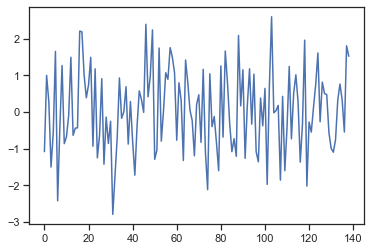

In [20]:
u0["Residual"].plot()

### Linear filters

In [21]:
# Check the value of lag (p) used in the Yule-Walker method through the AIC
# http://pages.stern.nyu.edu/~churvich/TimeSeries/Handouts/AICC.pdf
# page 2, formula 1

# AIC = n*(log(sigma^2) + 1) + 2*(p + 1)*n/(n-p-2)

AIC_table = pd.DataFrame(columns=results_states.keys())

def yule_walker_aic():
    '''
    The idea is to iterate through the 17 US states
    and for each state's GP residual, compute the AIC value for the Yule-Walker model for lags from 1-5
    as an extra step we also compute the AIC value according to the recommended lag by the ACF model in        
    MO-1 (descriptive_stats::lags small)
    '''

    for state in results_states.keys():
        state_residual = results_states[state][1]
        n = len(state_residual)
        AIC = []

        # Second method, fine tune the AIC for a series of lags
        for lag in range(7): 
            lag = lag + 1
            rho_, sigma_ = sm.regression.yule_walker(state_residual, order=lag, method="mle")
            p = len(rho_)
            AIC_i = np.round(n*(np.log(sigma_**2) + 1) + 2*(p + 1)*n/(n-p-2), 2)
            AIC.append(AIC_i)
  
        # Add the AIC results for each lag to the state column
        AIC_table[state] = AIC

In [22]:
# Run the script
# The table below shows the AIC for each lag by state
yule_walker_aic()
AIC_table

,Alaska,Alabama,Arkansas,Arizona,California,Colorado,Connecticut,District of Columbia,Delaware,Florida,Georgia,Hawaii,Iowa,Idaho,Illinois,Indiana,Kansas
0,-427.64,-633.66,-549.76,-637.03,-637.28,-581.52,-612.96,-662.95,-570.08,-673.30,-668.65,-380.70,-692.30,-507.33,-725.61,-735.62,-660.22
1,-425.59,-633.14,-547.68,-640.83,-635.31,-580.94,-610.90,-662.38,-568.78,-673.81,-666.57,-384.86,-701.43,-513.73,-732.43,-734.06,-658.76
2,-428.47,-632.85,-551.62,-640.68,-634.03,-583.16,-609.13,-666.42,-567.07,-671.86,-671.19,-383.70,-699.33,-511.71,-731.80,-732.83,-662.33
3,-426.38,-638.66,-549.91,-638.56,-643.91,-582.51,-610.27,-664.47,-566.57,-673.35,-669.05,-386.24,-697.33,-509.56,-729.66,-730.87,-662.80
4,-427.19,-636.50,-548.45,-638.32,-644.31,-582.89,-609.09,-667.49,-564.39,-673.80,-667.28,-384.32,-698.36,-509.74,-732.86,-728.70,-661.77
5,-429.10,-636.51,-555.83,-636.14,-642.28,-580.86,-607.95,-665.27,-562.50,-672.27,-665.20,-384.10,-696.38,-508.48,-730.67,-735.88,-659.99
6,-427.46,-641.30,-553.83,-633.90,-643.13,-580.91,-605.71,-669.18,-571.08,-671.12,-662.97,-390.71,-697.57,-508.55,-728.68,-733.70,-657.86


We perform a Yule-Walker autoregressive model fit on the residuals from each independent GP. What this model gives us is the variance and the coefficients for each state for the model noise to match a randomly generated Gaussian noise. 

In [23]:
linear_filters_states = {}

for state in results_states.keys():
    u0_ = u0[u0['Updated'].isin(train_data.loc[state, 'Updated'])]
    state_residual = results_states[state][1]
    t = u0_["Updated"].index.astype('float').values.reshape(-1, 1)

    def _yule_walker(u=None, coeff_=None, sigma_=None):
        return np.convolve(coeff_, u, mode="same")

    rho_, sigma_ = sm.regression.yule_walker(state_residual, order=ORDER, method="mle")
    rho_ = np.array(rho_)[::-1]
    linear_filters_states[state] = rho_, partial(
        _yule_walker, u=u0_["Residual"].values, coeff_=tuple(rho_), sigma_=sigma_
    )

### Rhos

In [26]:
rhos_mm = np.zeros((n_inducing_points*N, n_inducing_points*N))
for i, (hX, epsX) in enumerate(linear_filters_states.values()):
    for j, (hY, epsY) in enumerate(linear_filters_states.values()):
        convol = np.convolve(hX, hY[::-1], mode="same")
        for t in range(n_inducing_points):
            data = convol[max(len(convol)//2 - t, 0): min(len(convol), n_inducing_points - t + len(convol)//2)]
            jstart = j*n_inducing_points+max(t - len(convol)//2, 0)
            jend = jstart + len(data)
            rhos_mm[i*n_inducing_points+t, jstart:jend] = data

# validation
for x in range(N):
    for y in range(N):
        for t in range(n_inducing_points):
            for s in range(n_inducing_points):
                assert rhos_mm[x*n_inducing_points+t, y*n_inducing_points+s] == rhos_mm[y*n_inducing_points+s, x*n_inducing_points+t], \
                f"x={x}, y={y}, t={t}, s={s} => \rho^{{XY}}_{{t,s}} = \rho^{{YX}}_{{s,t}}"
                assert rhos_mm[y*n_inducing_points+t, x*n_inducing_points+s] == rhos_mm[x*n_inducing_points+s, y*n_inducing_points+t], \
                f"x={x}, y={y}, t={t}, s={s} => \rho^{{YX}}_{{t,s}} = \rho^{{XY}}_{{s,t}}"

In [27]:
rhos_mm.shape

(255, 255)

### Kmm

We add the Yule-Walker coefficients to the covariance kernel. 

In [28]:
Kmm = ks_mm + rhos_mm

In [29]:
Kmm_1 = tf.linalg.inv(Kmm)

---

## $K(X_*, X_*)$

### Marginal Kernels

This is the Knn but with the whole training data, so $2244\times 2444$. We will need it to compute the training variance.

In [30]:
ks_mm_tr = np.zeros((T_train*N, T_train*N))
for s_i, (state, (m_i, r_i, v_i)) in enumerate(results_states.items()):
    X, y = prepare_data(train_data.loc[state].iloc[ORDER-1:], state)
    k = m_i.kernel(X).numpy()
    ks_mm_tr[s_i*T_train:(s_i+1)*T_train, s_i*T_train:(s_i+1)*T_train] = k

In [31]:
ks_mm_tr.shape

(2244, 2244)

In [32]:
rhos_mm_tr = np.zeros((T_train*N, T_train*N))
for i, (hX, epsX) in enumerate(linear_filters_states.values()):
    for j, (hY, epsY) in enumerate(linear_filters_states.values()):
        convol = np.convolve(hX, hY[::-1], mode="same")
        for t in range(T_train):
            data = convol[max(len(convol)//2 - t, 0): min(len(convol), T_train - t + len(convol)//2)]
            jstart = j*T_train+max(t - len(convol)//2, 0)
            jend = jstart + len(data)
            rhos_mm_tr[i*T_train+t, jstart:jend] = data

# validation
for x in range(N):
    for y in range(N):
        for t in range(T_train):
            for s in range(T_train):
                assert rhos_mm_tr[x*T_train+t, y*T_train+s] == rhos_mm_tr[y*T_train+s, x*T_train+t], \
                f"x={x}, y={y}, t={t}, s={s} => \rho^{{XY}}_{{t,s}} = \rho^{{YX}}_{{s,t}}"
                assert rhos_mm_tr[y*T_train+t, x*T_train+s] == rhos_mm_tr[x*T_train+s, y*T_train+t], \
                f"x={x}, y={y}, t={t}, s={s} => \rho^{{YX}}_{{t,s}} = \rho^{{XY}}_{{s,t}}"

In [33]:
Kmm_tr = ks_mm_tr + rhos_mm_tr

Now, this is the Knn but with the test data. We will need this to compute the test variance.

In [34]:
ks_nn = np.zeros((T_test*N, T_test*N))
for s_i, (state, (m_i, r_i, v_i)) in enumerate(results_states.items()):
    X, y = prepare_data(test_data.loc[state], state)
    k = m_i.kernel(X).numpy()
    ks_nn[s_i*T_test:(s_i+1)*T_test, s_i*T_test:(s_i+1)*T_test] = k

In [35]:
ks_nn.shape

(238, 238)

### Rhos

In [36]:
rhos_nn = np.zeros((T_test*N, T_test*N))
for i, (hX, epsX) in enumerate(linear_filters_states.values()):
    for j, (hY, epsY) in enumerate(linear_filters_states.values()):
        hX_test = hX
        hY_test = hY
        convol = np.convolve(hX_test, hY_test[::-1], mode="same")
        for t in range(T_test):
            data = convol[max(len(convol)//2 - t, 0): min(len(convol), T_test - t + len(convol)//2)]
            jstart = j*T_test+max(t - len(convol)//2, 0)
            jend = jstart + len(data)
            rhos_nn[i*T_test+t, jstart:jend] = data

# validation
for x in range(N):
    for y in range(N):
        for t in range(T_test):
            for s in range(T_test):
                assert rhos_nn[x*T_test+t, y*T_test+s] == rhos_nn[y*T_test+s, x*T_test+t], \
                f"x={x}, y={y}, t={t}, s={s} => rho^XY_t,s = rho^YX_s,t"
                assert rhos_nn[y*T_test+t, x*T_test+s] == rhos_nn[x*T_test+s, y*T_test+t], \
                f"x={x}, y={y}, t={t}, s={s} => rho^YX_t,s = rho^XY_s,t"

In [37]:
rhos_nn.shape

(238, 238)

### Knn

In [38]:
Knn = ks_nn + rhos_nn

---

## $K(X, X_*)$

### Marginal Kernels

This is the Kmn for the training data, so $255\times 2244$ (inducing x training). We need it for variance and mean 

In [39]:
ks_mn_tr = np.zeros((15*N, T_train*N))
for s_i, (state, (m_i, r_i, v_i)) in enumerate(results_states.items()):
    X_train, y_train = prepare_data(train_data.loc[state].iloc[ORDER-1:], state)
    k = m_i.kernel(m_i.inducing_variable.Z, X_train).numpy()
    ks_mn_tr[s_i*15:(s_i+1)*15, s_i*T_train:(s_i+1)*T_train] = k

In [40]:
ks_mn_tr.shape

(255, 2244)

This is the Kmn, $255\times 238$ (inducing x test data)

In [41]:
ks_mn = np.zeros((n_inducing_points*N, T_test*N))
for s_i, (state, (m_i, r_i, v_i)) in enumerate(results_states.items()):
    X_test, y_test = prepare_data(test_data.loc[state], state)
    k = m_i.kernel(m_i.inducing_variable.Z, X_test).numpy()
    ks_mn[s_i*n_inducing_points:(s_i+1)*n_inducing_points, s_i*T_test:(s_i+1)*T_test] = k

In [42]:
ks_mn.shape

(255, 238)

---

## $K(X_*, X)$

### Marginal Kernels

This is the Knm for the training data, so $2244\times 255$ (training x inducing). We need it for variance and mean

In [43]:
ks_nm_tr = np.zeros((T_train*N, n_inducing_points*N))
for s_i, (state, (m_i, r_i, v_i)) in enumerate(results_states.items()):
    X_train, y_train = prepare_data(train_data.loc[state].iloc[ORDER-1:], state)
    k = m_i.kernel(X_train, m_i.inducing_variable.Z).numpy()
    ks_nm_tr[s_i*T_train:(s_i+1)*T_train, s_i*n_inducing_points:(s_i+1)*n_inducing_points] = k

In [44]:
ks_nm_tr.shape

(2244, 255)

This is the Knm, $233\times 255$ (test data x inducing)

In [45]:
ks_nm = np.zeros((T_test*N, n_inducing_points*N))
for s_i, (state, (m_i, r_i, v_i)) in enumerate(results_states.items()):
    X_test, y_test = prepare_data(test_data.loc[state], state)
    k = m_i.kernel(X_test, m_i.inducing_variable.Z).numpy()
    ks_nm[s_i*T_test:(s_i+1)*T_test, s_i*n_inducing_points:(s_i+1)*n_inducing_points] = k

In [46]:
ks_nm.shape

(238, 255)

---

## Prediction

In [47]:
y_train = np.empty((T_train*N,1))
y_test = np.empty((T_test*N,1))
for s_i, state in enumerate(results_states.keys()):
    _, y_tr = prepare_data(train_data.loc[state].iloc[ORDER-1:], state)
    _, y_te = prepare_data(test_data.loc[state], state)
    y_train[s_i*T_train:(s_i+1)*T_train,:] = y_tr
    y_test[s_i*T_test:(s_i+1)*T_test,:] = y_te

In [48]:
y_train.shape, y_test.shape

((2244, 1), (238, 1))

In [123]:
# The variational mean values of the inducing points
q_mu_train = np.concatenate([results_states[s][0].q_mu.numpy() for s in results_states.keys()])

# Create a noise diagonal to make the matrix PSD
a = np.zeros(Kmm.shape)
np.fill_diagonal(a, 1)

# Perfom Cholesky decomposition on the matrix
Lm = tf.linalg.cholesky(Kmm + a)

# Compute the train set
A_train = tf.linalg.triangular_solve(Lm, ks_mn_tr, lower=True) 

var_train = Kmm_tr + tf.linalg.matmul(A_train, A_train, transpose_a=True)

mean_train = tf.linalg.matmul(A_train, q_mu_train, transpose_a=True)


# Perform the same for the test set
A_test = tf.linalg.triangular_solve(Lm, ks_mn, lower=True) 

var_test = Knn + tf.linalg.matmul(A_test, A_test, transpose_a=True)

mean_test = tf.linalg.matmul(A_test, q_mu_train, transpose_a=True)

In [54]:
pd.DataFrame(Kmm).to_csv("Kmm.csv")

In [46]:
# We need the variational mean since we use the inducing points
q_mu_train = np.concatenate([results_states[s][0].q_mu.numpy() for s in results_states.keys()])


# train
A_train = tf.linalg.matmul(ks_nm_tr, Kmm_1)

mean_train = tf.linalg.matmul(A_train, q_mu_train)
var_train = Kmm_tr - tf.linalg.matmul(A_train, ks_mn_tr)

# test
A_test = tf.linalg.matmul(ks_nm, Kmm_1)

mean_test = tf.linalg.matmul(A_test, q_mu_train)
var_test = Knn - tf.linalg.matmul(A_test, ks_mn)

In [45]:
#pd.DataFrame(A_train.numpy()).to_csv("A_train_sparse.csv")
#pd.DataFrame(A_test.numpy()).to_csv("A_test_sparse.csv")

In [51]:
#pd.DataFrame(ks_nm_tr).to_csv("ks_nm_tr.csv")
#pd.DataFrame(Kmm_tr).to_csv("Kmm_tr.csv")
#pd.DataFrame(Kmm_1.numpy()).to_csv("Kmm_1.csv")
#pd.DataFrame(Kmm).to_csv("Kmm.csv")
#pd.DataFrame(ks_nm).to_csv("ks_nm.csv")
#pd.DataFrame(Knn).to_csv("Knn.csv")

In [124]:
y_trains = dict(zip(results_states.keys(), tf.split(y_train, N)))
y_tests = dict(zip(results_states.keys(), tf.split(y_test, N)))
y_var = tf.linalg.diag_part(var_train)
y_var = dict(zip(results_states.keys(), tf.split(y_var, N)))

y_hat_trains = dict(zip(results_states.keys(), tf.split(mean_train, N)))
y_hat_tests = dict(zip(results_states.keys(), tf.split(mean_test, N)))
y_hat_var = tf.linalg.diag_part(var_test)
y_hat_var = dict(zip(results_states.keys(), tf.split(var_test, N)))

for y_dict in (y_trains, y_tests, y_hat_trains, y_hat_tests):
    for k, v in y_dict.items():
        y_dict[k] = v[:,0]

In [125]:
def plot_for_state(state, ax=None):
    if not ax:
        _fig, ax = plt.subplots(1, figsize=(15, 4))
        
    t_test = test_data.loc[state]["index"].values
    t = train_data.loc[state].iloc[ORDER-1:]["index"].values

    y = y_trains[state]
    y_test = y_tests[state]
    y_hat = np.concatenate([y_hat_trains[state], y_hat_tests[state]])
    y_hat_variance = np.concatenate([y_var, y_hat_var])

    lo = (y_hat - 2 * tf.sqrt(var[:, s])).numpy()
    hi = (y_hat + 2 * tf.sqrt(var[:, s])).numpy()
    ax.fill_between(np.concatenate([t, t_test]).flatten(), lo.flatten(), hi.flatten(), alpha=0.3)

    ax.plot(np.concatenate([t, t_test]), y_hat, "-", c="C0")
    ax.plot(t, y, "o", c="C2", alpha=0.7, label="train")
    ax.plot(t_test, y_test, "o", c="C3", alpha=0.7, label="test")
    ax.legend()
    ax.set_title(state)

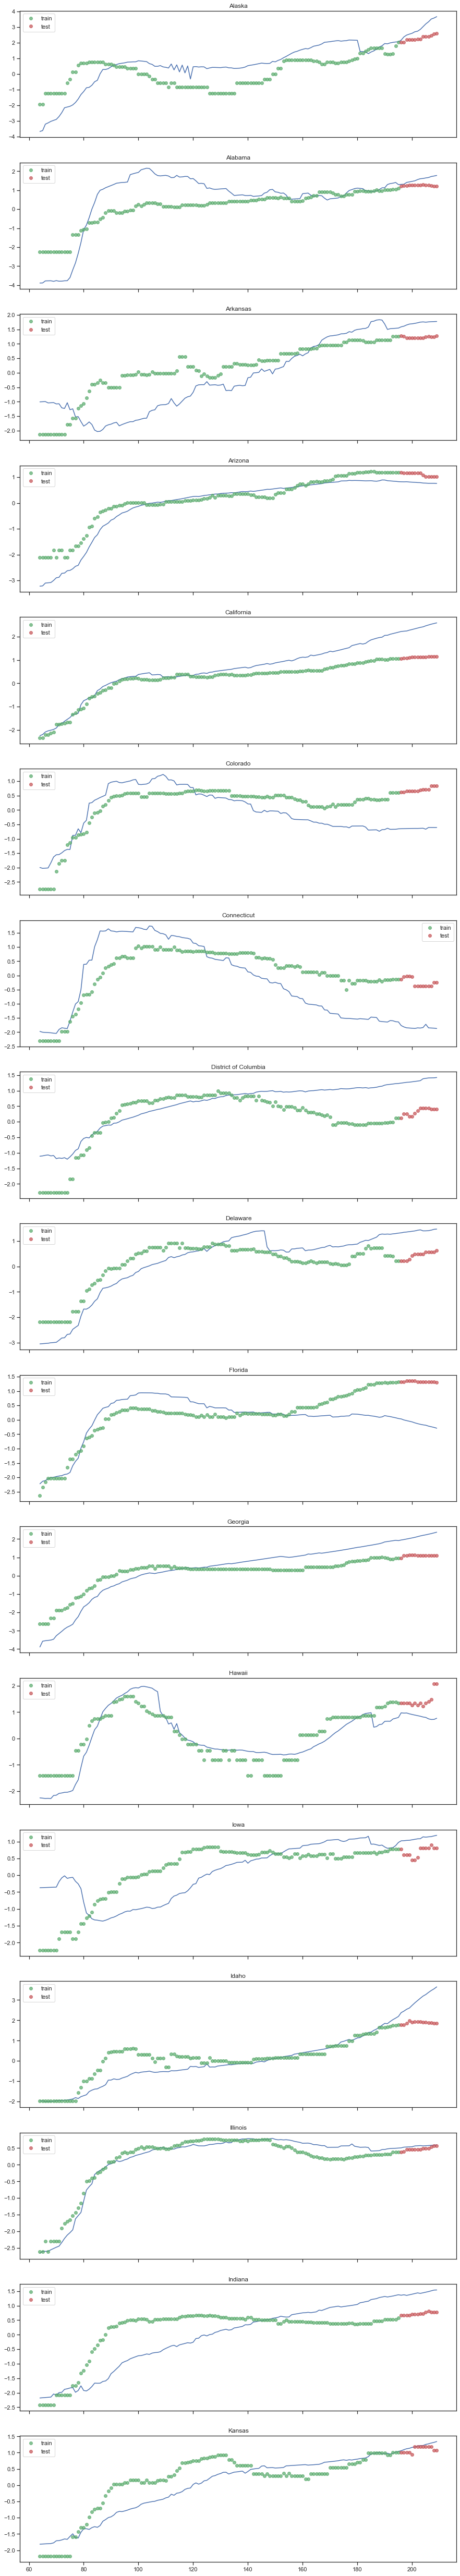

In [126]:
fig, axs = plt.subplots(N, 1, sharex=True, figsize=(15, 90))
for i, s in enumerate(results_states.keys()):
    ax = axs[i]
    plot_for_state(s, ax=ax)

In [62]:
x_tr, _ = prepare_data(train_data.loc["Alaska"].iloc[ORDER-1:], "Alaska")
x_tr.shape

(132, 6)

In [68]:
def plot_for_state(state, ax=None):
    if not ax:
        _fig, ax = plt.subplots(1, figsize=(15, 4))
        
    x_tr, _ = prepare_data(train_data.loc[state].iloc[ORDER-1:], state)
    x_te, _ = prepare_data(test_data.loc[state], state)

    t_test = test_data.loc[state]["index"].values
    t = train_data.loc[state].iloc[ORDER-1:]["index"].values

    y = y_trains[state]
    y_test = y_tests[state]

    y_hat_trains, _ = results_states[state][0].predict_y(x_tr)
    y_hat_tests, _ = results_states[state][0].predict_y(x_te)
    y_hat = np.concatenate([y_hat_trains, y_hat_tests])

    ax.plot(np.concatenate([t, t_test]), y_hat, "-", c="C0")
    ax.plot(t, y, "o", c="C2", alpha=0.7, label="train")
    ax.plot(t_test, y_test, "o", c="C3", alpha=0.7, label="test")
    ax.legend()
    ax.set_title(state)

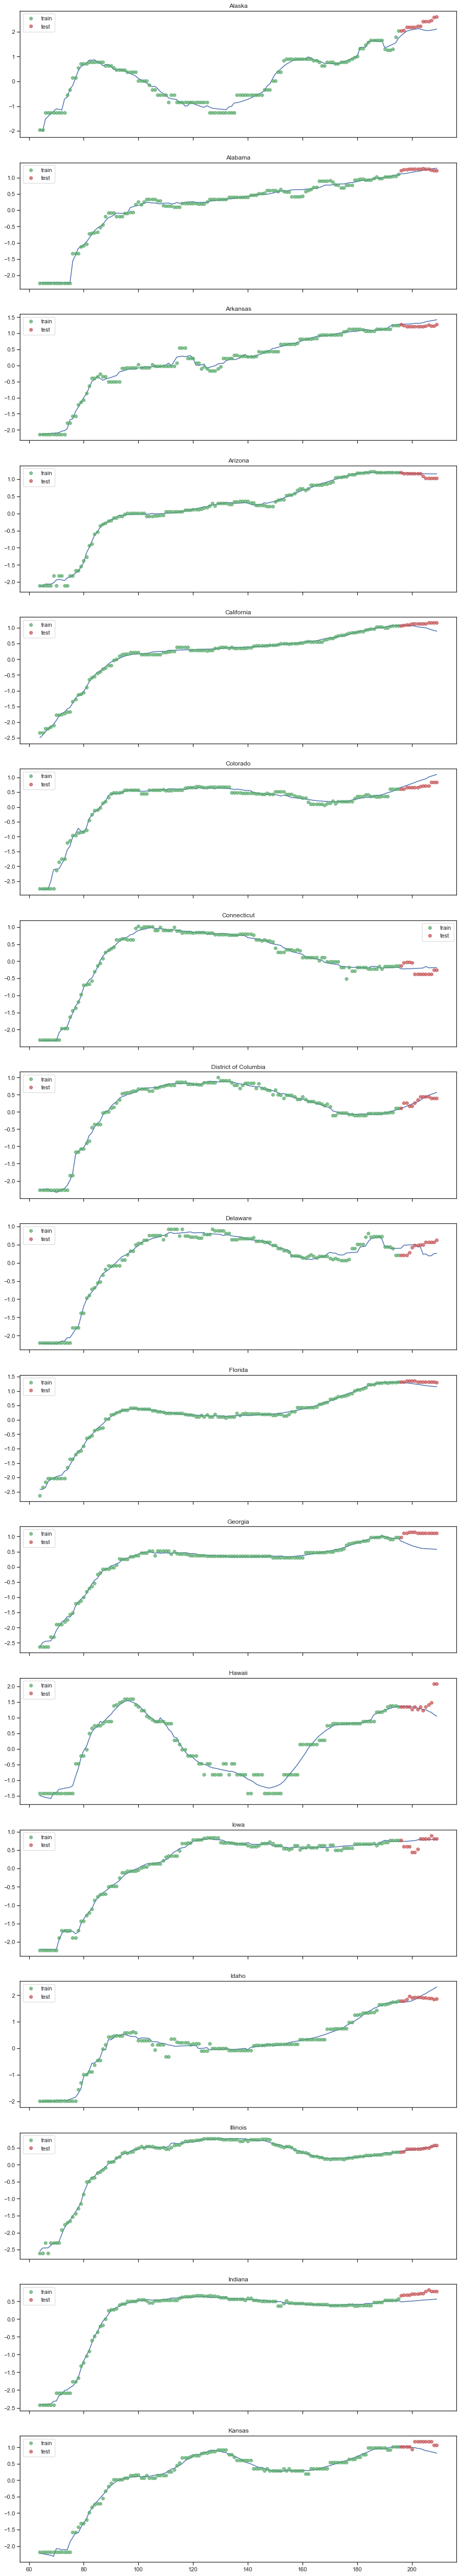

In [69]:
fig, axs = plt.subplots(N, 1, sharex=True, figsize=(15, 90))
for i, s in enumerate(results_states.keys()):
    ax = axs[i]
    plot_for_state(s, ax=ax)